# Методы исследования характеристических свойств нейронных сетей с применением теоретико-игрового подхода

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru
- **Поддержка CUDA**: А.Е.Григорьева admin@linkennt.ru
- **Ревизия**: 8

- **Другие ревизии**: [ссылка](https://disk.yandex.ru/d/aZozDpBlzh_z1A)
<!-- please do not append text into this block -->

- [x] Добавить 2x больше эпох на датасетах, где был плохой перфоманс (1, 2, 5, 7, 8)
- [x] Примешивать к целевой переменной на этапе обучения шум с амплитудой ~0,03 дисперсии
- [x] Обучить модели без шума для сравнения
- [ ] Отображать правильную шкалу шума
- [ ] Подмешивать стабильно распределённый шум, варьируя $\alpha$ от 1 до 2

NOTE: levy distribution нам не подходит, у него фиксированная $\alpha = 0.5$


## Setup

In [1]:
from cgtnnlib.constants import LEARNING_RATE, RANDOM_STATE
import cgtnnlib.training as tr
import cgtnnlib.datasets as ds
from cgtnnlib.ExperimentParameters import ExperimentParameters
from cgtnnlib.NoiseGenerator import target_dispersion_scaled_noise, stable_noise, no_noise_generator


iterations = 10
epochs = 10
dataset = ds.datasets[2]
pp = [0.0, 0.5, 0.9]


datasets = [
    ds.datasets['StudentPerformanceFactors'],
    ds.datasets['wine_quality'],
]

ng_makers = [
    # lambda _: no_noise_generator,
    # lambda dataset: target_dispersion_scaled_noise(
    #     dataset=dataset,
    #     factor=0.03,
    #     random_seed=RANDOM_STATE + 1,
    # ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1.25,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1.5,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1.75,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=2.0,
        beta=1,
    ),
]

double_epochs_datasets = [
    ds.datasets[0], # 1
    ds.datasets[1], # 2
    ds.datasets[4], # 5
    ds.datasets[6], # 7
    ds.datasets[7], # 8
]

TORCH_DEVICE is cpu



## Генерация стабильного шума

Используется алгоритм Chambers-Mallows-Stuck (CMS) [1]; в [2] алгоритм дан в прямом виде. Реализация в файле *cgtnnlib/NoiseGenerator.py*.

In [2]:

from cgtnnlib.NoiseGenerator import stable_noise

ng = stable_noise(
    dataset=datasets[0],
    factor=0.03,
    alpha=1,
    beta=0.0
)

print(ng.name)
[ng.next_sample() for _ in range(10)]

Stable3A1B0.0F0.03


[1.5875634224074302,
 0.3670740521099562,
 0.5616123053672906,
 -0.5450033868288063,
 4.0931009903852225,
 -0.13369720708106494,
 0.3167203156788216,
 0.11038890820372677,
 0.22416728700110805,
 -1.1001065325029875]

## Training

- both take ~5m 06s to train 10 iterations
- both on both noises: about ~10m

<hr>

- `ds.datasets['StudentPerformanceFactors']` takes ~2m 30s to train 10 iterations
- `ds.datasets['wine_quality']` takes ~2m 36s to train 10 iterations

### Target noise

In [3]:
for i, dataset in enumerate(datasets):
    for ng_maker in ng_makers:
        for p in pp:
            noise_generator = ng_maker(dataset)
            for iteration in range(iterations):
                experiment_params = ExperimentParameters(iteration, p=p)

                tr.create_and_train_model(
                    dataset,
                    epochs,
                    learning_rate=LEARNING_RATE,
                    dry_run=False,
                    p=p,
                    iteration=iteration,
                    noise_generator=noise_generator,
                    must_not_exist=False
                )

N=9 #6 gStable6A2.0B1F0.03 p=0.9 E9/10 S434 Loss=nan@AugmentedReLUNetwork
create_and_train_model(): saved model to pth//cgtnn-6Y-AugmentedReLUNetwork-gStable6A2.0B1F0.03-P0.9_N9.pth
Report saved to pth/cgtnn-6Y-AugmentedReLUNetwork-gStable6A2.0B1F0.03-P0.9_N9.json.


### 2x epochs

In [3]:
for i, dataset in enumerate(double_epochs_datasets):
    for p in pp:
        for iteration in range(iterations):
            experiment_params = ExperimentParameters(iteration, p=p)

            tr.create_and_train_model(
                dataset,
                epochs * 2,
                learning_rate=LEARNING_RATE,
                dry_run=False,
                p=p,
                iteration=iteration,
                noise_generator=no_noise_generator
            )

N=9 #8 gNoNoise p=0.9 E19/20 S81 Loss=4.2432@AugmentedReLUNetwork
create_and_train_model(): saved model to pth//cgtnn-8Y-AugmentedReLUNetwork-gNoNoise-P0.9_N9.pth
Report saved to pth/cgtnn-8Y-AugmentedReLUNetwork-gNoNoise-P0.9_N9.json.


## Evaluation

both take 42s

120 take 4m 10.9s

(need evaluation skip check??)

In [ ]:
from cgtnnlib.EvaluationParameters import EvaluationParameters
from cgtnnlib.Report import Report
from cgtnnlib.nn.AugmentedReLUNetwork import AugmentedReLUNetwork
import cgtnnlib.evaluate as ev
import cgtnnlib.datasets as ds
import cgtnnlib.path as ph
from cgtnnlib.ExperimentParameters import ExperimentParameters

## All others
for i, dataset in enumerate(datasets):
    for ng_maker in ng_makers:
        for p in pp:
## 2x epochs
# for i, dataset in enumerate(double_epochs_datasets):
#     for p in pp:
#         for iteration in range(iterations):
            
            ## All others

            noise_generator = ng_maker(dataset)
            
            ## 2x epochs
            
            # noise_generator = no_noise_generator

            for iteration in range(iterations):
                experiment_params = ExperimentParameters(iteration, p=p)
                
                eval_params = EvaluationParameters(
                    dataset=dataset,
                    model_path=ph.model_path(
                        dataset_number=dataset.number,
                        model_type=AugmentedReLUNetwork,
                        p=p,
                        iteration=iteration,
                        noise_generator=noise_generator,
                    ),
                    experiment_parameters=experiment_params,
                    report_key=ph.eval_report_key(
                        model_name=AugmentedReLUNetwork.__name__,
                        dataset_number=dataset.number,
                        p=p,
                        iteration=iteration,
                    )
                )
                
                report_name = ph.model_name(
                    dataset_number=dataset.number,
                    model_type=AugmentedReLUNetwork,
                    p=p,
                    iteration=iteration,
                    noise_generator=noise_generator
                )
                
                report = Report(
                    dir='pth/',
                    filename=report_name + '.json',
                    must_exist=True,
                )
                
                ev.eval_inner(
                    eval_params=eval_params,
                    constructor=AugmentedReLUNetwork,
                    report=report
                )
                
                report.save()

NoiseGenerator(name='Stable3A1B1F0.03', next_sample=<function stable_noise.<locals>.<lambda> at 0x18f3a11c0>) cgtnn-3Y-AugmentedReLUNetwork-gStable3A1B1F0.03-P0.0_N0
Report found at pth/cgtnn-3Y-AugmentedReLUNetwork-gStable3A1B1F0.03-P0.0_N0.json. Loading...
Report loaded.
Skipping evaluation.
Report saved to pth/cgtnn-3Y-AugmentedReLUNetwork-gStable3A1B1F0.03-P0.0_N0.json.
NoiseGenerator(name='Stable3A1B1F0.03', next_sample=<function stable_noise.<locals>.<lambda> at 0x18f3a11c0>) cgtnn-3Y-AugmentedReLUNetwork-gStable3A1B1F0.03-P0.0_N1
Report found at pth/cgtnn-3Y-AugmentedReLUNetwork-gStable3A1B1F0.03-P0.0_N1.json. Loading...
Report loaded.
Skipping evaluation.
Report saved to pth/cgtnn-3Y-AugmentedReLUNetwork-gStable3A1B1F0.03-P0.0_N1.json.
NoiseGenerator(name='Stable3A1B1F0.03', next_sample=<function stable_noise.<locals>.<lambda> at 0x18f3a11c0>) cgtnn-3Y-AugmentedReLUNetwork-gStable3A1B1F0.03-P0.0_N2
Report found at pth/cgtnn-3Y-AugmentedReLUNetwork-gStable3A1B1F0.03-P0.0_N2.json

## Analysis

In [5]:
## Regular

import json

import pandas as pd

import matplotlib.pyplot as plt

from cgtnnlib.analyze import plot_deviant_curves_on_ax_or_plt



def read_json(path: str) -> dict:
    with open(path) as file:
        return json.load(file)

def summarize_series_list(series_list: list[pd.Series]):
    df = pd.DataFrame(series_list).T

    summary_df = pd.DataFrame({
        0.25: df.quantile(0.25, axis=1),
        0.75: df.quantile(0.75, axis=1),
        'mean': df.mean(axis=1),
    })

    return summary_df

for dataset in datasets:
    for p in pp:
        prefixes = [
            f'cgtnn-{dataset.number}Y-AugmentedReLUNetwork-g{ng_maker(dataset).name}-P{p}_'
            for ng_maker in ng_makers
        ]
        
        files = [
            [
                pd.DataFrame(
                    read_json(
                        'pth/' + prefix + 'N' + str(n) + '.json'
                    )['eval']
                )
                for n in range(iterations)
            ]
            for prefix in prefixes
        ]

        no_noise = summarize_series_list([file['mse'] for file in files[0]])
        some_noise = summarize_series_list([file['mse'] for file in files[1]])

        print(no_noise)
        
        plot_deviant_curves_on_ax_or_plt(
            ax_or_plt=plt,
            models=[{
                'curve': no_noise,
                'color': 'blue',
                'label': 'Без шума',
                'quantiles_color': 'lightblue',
                'quantiles_label': 'Квартили 0,25; 0,75',
            }, {
                'curve': some_noise,
                'color': 'purple',
                'label': 'С шумом 0,03 дисперсии целевой переменной',
                'quantiles_color': 'pink',
                'quantiles_label': 'Квартили 0,25; 0,75', 
            }],
            title='\n'.join([
                # 'Кривая потерь, обучение с +0.03 шумом на входе',
                'Зависимость MSE от шума на входе',
                f'p = {p}',
                f'Датасет #{dataset.number}: {dataset.name}'
            ]),
            xlabel='Шум на входе',
            ylabel='MSE',
            quantiles_alpha=0.5,
        )
        plt.show()

KeyError: 'eval'

pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N0.json


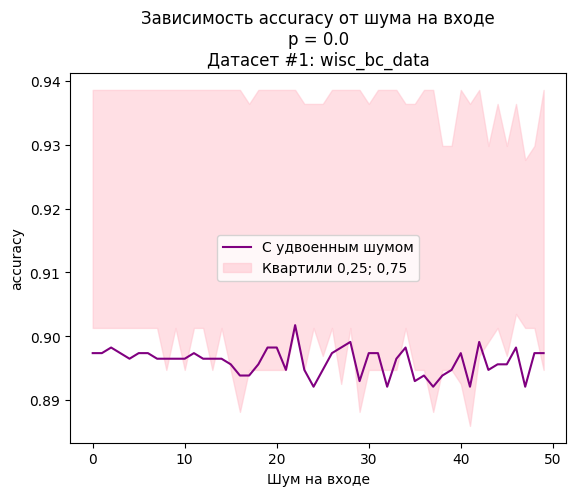

pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.5_N0.json


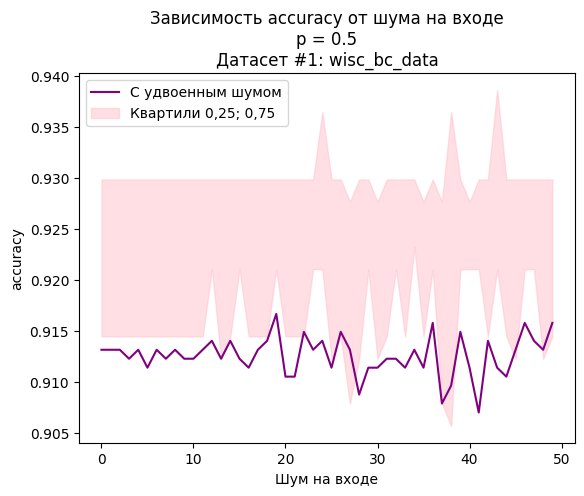

pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.9_N0.json


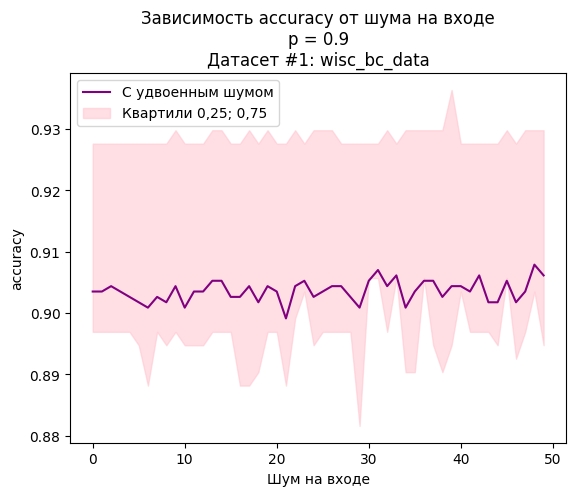

pth/cgtnn-2Y-AugmentedReLUNetwork-gNoNoise-P0.0_N0.json


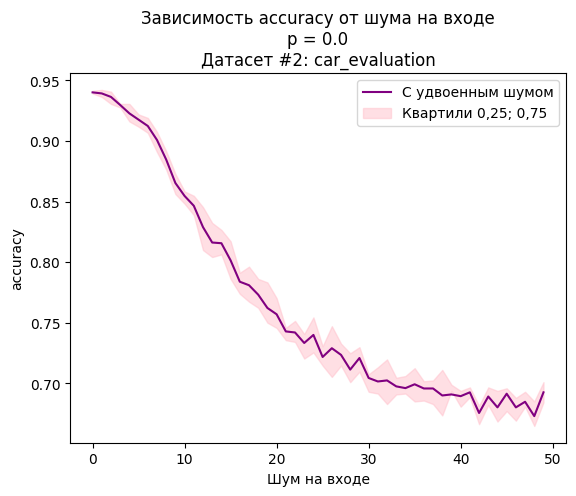

pth/cgtnn-2Y-AugmentedReLUNetwork-gNoNoise-P0.5_N0.json


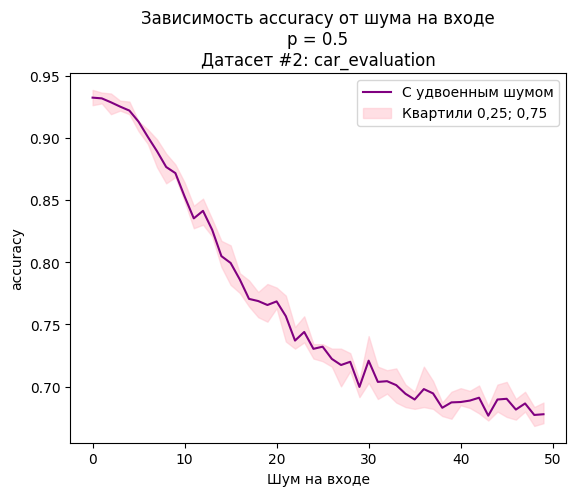

pth/cgtnn-2Y-AugmentedReLUNetwork-gNoNoise-P0.9_N0.json


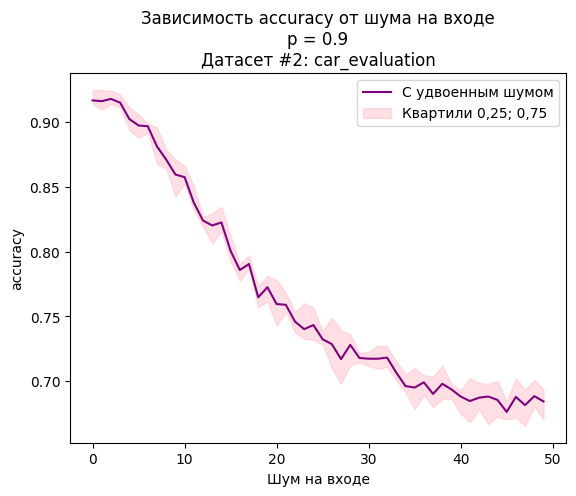

pth/cgtnn-5Y-AugmentedReLUNetwork-gNoNoise-P0.0_N0.json


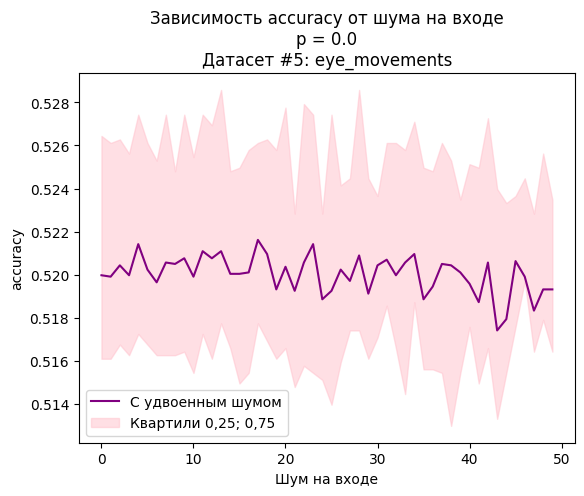

pth/cgtnn-5Y-AugmentedReLUNetwork-gNoNoise-P0.5_N0.json


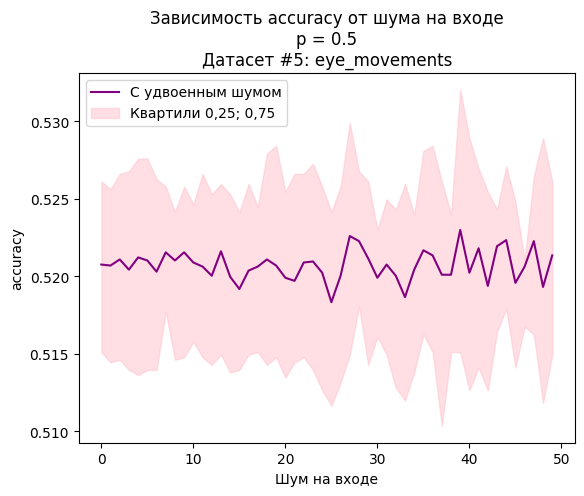

pth/cgtnn-5Y-AugmentedReLUNetwork-gNoNoise-P0.9_N0.json


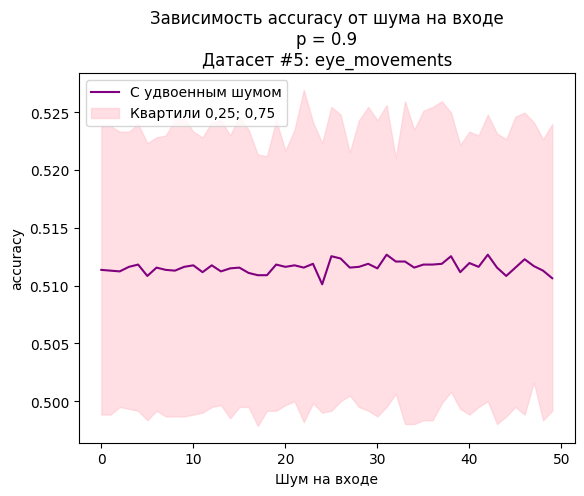

pth/cgtnn-7Y-AugmentedReLUNetwork-gNoNoise-P0.0_N0.json


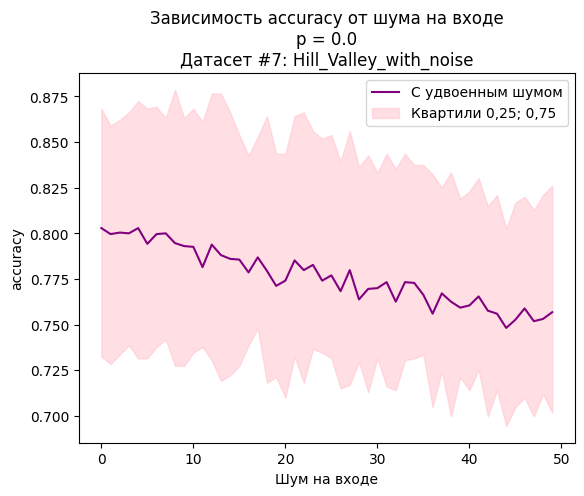

pth/cgtnn-7Y-AugmentedReLUNetwork-gNoNoise-P0.5_N0.json


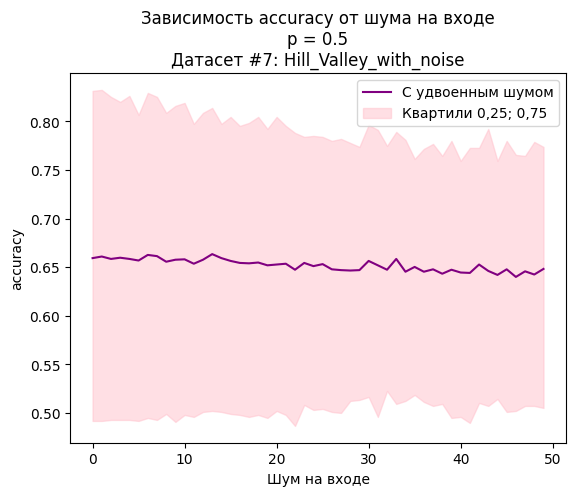

pth/cgtnn-7Y-AugmentedReLUNetwork-gNoNoise-P0.9_N0.json


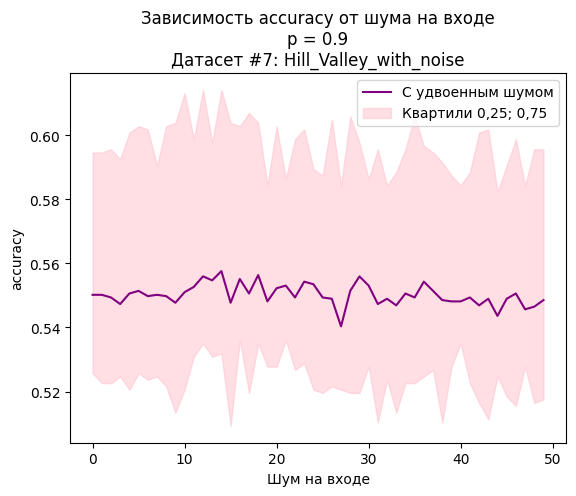

pth/cgtnn-8Y-AugmentedReLUNetwork-gNoNoise-P0.0_N0.json


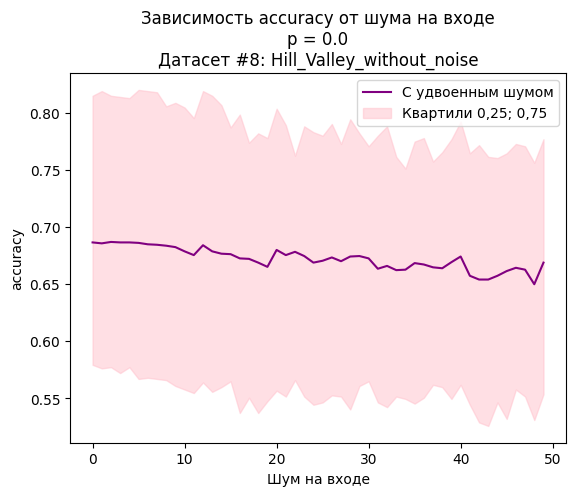

pth/cgtnn-8Y-AugmentedReLUNetwork-gNoNoise-P0.5_N0.json


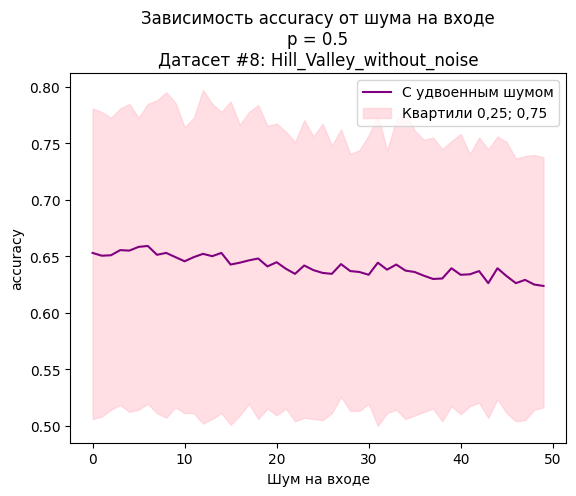

pth/cgtnn-8Y-AugmentedReLUNetwork-gNoNoise-P0.9_N0.json


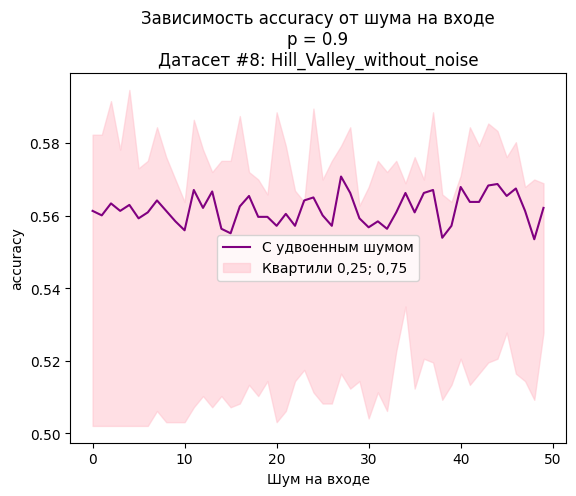

In [17]:
## 2x epochs

import json

import pandas as pd

import matplotlib.pyplot as plt

from cgtnnlib.analyze import plot_deviant_curves_on_ax_or_plt



def read_json(path: str) -> dict:
    with open(path) as file:
        return json.load(file)

def summarize_series_list(series_list: list[pd.Series]):
    df = pd.DataFrame(series_list).T

    summary_df = pd.DataFrame({
        0.25: df.quantile(0.25, axis=1),
        0.75: df.quantile(0.75, axis=1),
        'mean': df.mean(axis=1),
    })

    return summary_df

for i, dataset in enumerate(double_epochs_datasets):
    for p in pp:
        prefix = (
            f'cgtnn-{dataset.number}Y-AugmentedReLUNetwork'
            +f'-g{no_noise_generator.name}-P{p}_'
        )

        metric = 'accuracy'

        def filename(n):
            return f'pth/{prefix}N{n}.json'

        files = [
            pd.DataFrame(
                read_json(filename(n))['eval']
            )
            for n in range(iterations)
        ]
        
        print(filename(0))

        double_epochs = summarize_series_list([file[metric] for file in files])

        plot_deviant_curves_on_ax_or_plt(
            ax_or_plt=plt,
            models=[{
                'curve': double_epochs,
                'color': 'purple',
                'label': 'С удвоенным шумом',
                'quantiles_color': 'pink',
                'quantiles_label': 'Квартили 0,25; 0,75', 
            }],
            title='\n'.join([
                # 'Кривая потерь, обучение с +0.03 шумом на входе',
                f'Зависимость {metric} от шума на входе',
                f'p = {p}',
                f'Датасет #{dataset.number}: {dataset.name}'
            ]),
            xlabel='Шум на входе',
            ylabel=metric,
            quantiles_alpha=0.5,
        )
        plt.show()

## References

1. Chambers, J. M., Mallows, C. L., & Stuck, B. W. (1976). A method for simulating stable random variables. *Journal of the American Statistical Association*, *71*(354), 340-344.
2. M. Firouzi, A. Mohammadpour. A Survey on Simulating Stable Random Variables. URL: https://www.semanticscholar.org/reader/11a1e93642dc0a5c94e6906bcca5e4d25d4e9d46